In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
n_landmarks = 40
n_bins = 10

In [ ]:
from sklearn.cluster import KMeans
from scipy.optimize import bracket, minimize_scalar

def generate_landmarks(X, n_landmarks, method='kmeans'):
    if method == 'kmeans':
        kmeans = KMeans(n_landmarks)
        kmeans.fit(X)
        return kmeans.cluster_centers_
    elif method == 'random':
        return X[np.random.choice(X.shape[0], size=n_landmarks, replace=False)]

def pairwise_squared_distance(X, L=None):
    if L is None:
        P = X @ X.T
        return P.diagonal().reshape(-1, 1) + P.diagonal().reshape(1, -1) - 2 * P
    else:
        return np.sum(np.square(X), axis=1).reshape(-1, 1) + np.sum(np.square(L), axis=1).reshape(1, -1) - 2 * X @ L.T

def closest_landmark(X, L):
    D = pairwise_squared_distance(X, L)
    return np.argmin(D, axis=1)

def negative_kernel_entropy(sigma2, squared_distances, n_bins=10):
    K = np.exp(-squared_distances / (2 * sigma2))
    H, _ = np.histogram(K, bins=n_bins, range=(0, 1))
    H = H / H.sum()
    return np.sum(H * np.log(H + 1e-10))

def maximize_kernel_entropy(squared_distances, n_bins=10):
    fun = partial(negative_kernel_entropy, squared_distances=squared_distances, n_bins=n_bins)
    xa_0 = 1e-10
    xb_0 = np.mean(squared_distances)
    
    try:
        xa, xb, xc, _, _, _, funcalls = bracket(fun, xa_0, xb_0)
    except:
        print("Kernel entropy maximization: Failed to bracket local maximum.")
    else:
        result = minimize_scalar(fun, bracket=(xa, xb, xc))
        if result.success:
            funcalls += result.nfev
            return result.x, -result.fun, funcalls
        else:
            print("Kernel entropy maximization: Optimization failed.")

    print("Setting sigma2 to the mean squared distance.")
    sigma2 = xb_0
    kernel_entropy = -negative_kernel_entropy(sigma2, squared_distances, n_bins)
    return sigma2, kernel_entropy, None

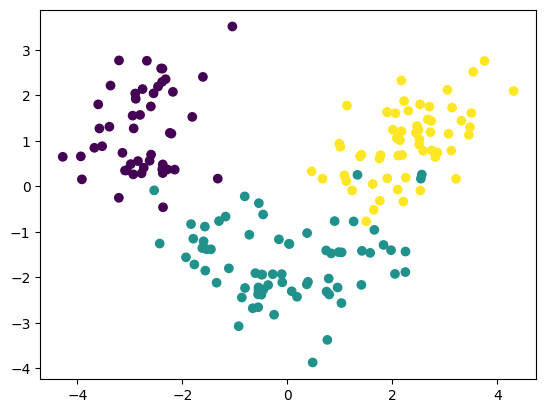

In [4]:
data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

Y_unique = np.unique(Y_original)
indx = np.argsort([np.mean(X_reduced[Y_original == label, 0]) for label in Y_unique])
label_map = {Y_unique[j]: i for i, j in enumerate(indx)}
Y_mapped = np.vectorize(label_map.get)(Y_original)

indx = np.lexsort((X_reduced[:, 1], X_reduced[:, 0], Y_mapped))
X_scaled = X_scaled[indx]
X_reduced = X_reduced[indx]
Y_mapped = Y_mapped[indx]

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y_mapped)

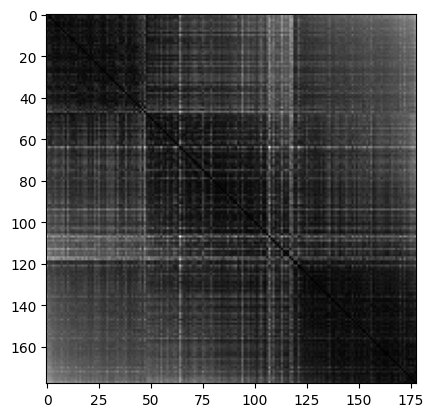

In [5]:
D = pairwise_squared_distance(X_scaled)
plt.imshow(D, cmap='gray')

In [6]:
sigma2, kernel_entropy, funcalls = maximize_kernel_entropy(D, n_bins=n_bins)
print(f"Optimal sigma2: {sigma2:.2f}, Kernel entropy: {kernel_entropy:.2f}, Function calls: {funcalls:d}")

Optimal sigma2: 13.11, Kernel entropy: 2.08, Function calls: 38


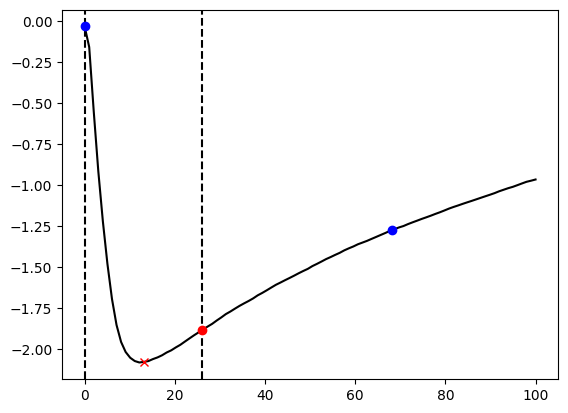

In [7]:
x = np.linspace(1e-10, 100, 100)
y = [negative_kernel_entropy(sigma2, D, n_bins=n_bins) for sigma2 in x]

xa_0 = 1e-10
xb_0 = np.mean(D)
fun = partial(negative_kernel_entropy, squared_distances=D, n_bins=n_bins)
xa, xb, xc, fa, fb, fc, _ = bracket(fun, xa_0, xb_0)

plt.plot(x, y, "-k")
plt.axvline(x=xa_0, color="k", linestyle="--")
plt.axvline(x=xb_0, color="k", linestyle="--")
plt.plot(xa, fa, "bo")
plt.plot(xb, fb, "ro")
plt.plot(xc, fc, "bo")
plt.plot(sigma2, -kernel_entropy, 'rx')

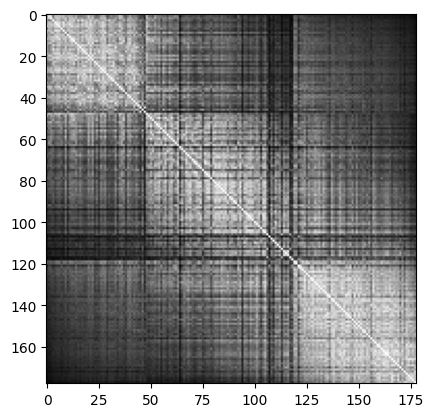

In [8]:
K = np.exp(-D / (2 * sigma2))
plt.imshow(K, cmap='gray')

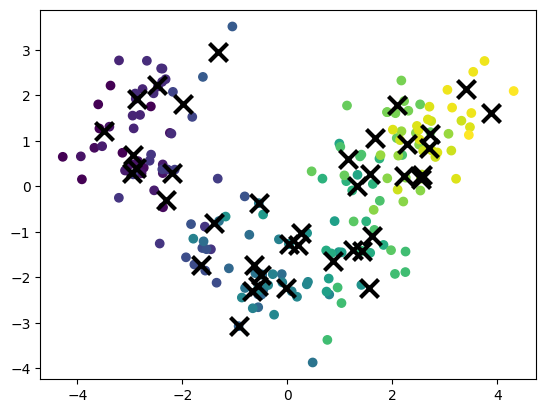

In [9]:
L = generate_landmarks(X_scaled, n_landmarks)
L_reduced = pca.transform(L)

indx = np.lexsort((L_reduced[:, 1], L_reduced[:, 0]))
L = L[indx]
L_reduced = L_reduced[indx]

Y = closest_landmark(X_scaled, L)

indx = np.lexsort((X_reduced[:, 1], X_reduced[:, 0], Y, Y_mapped))
X_scaled = X_scaled[indx]
X_reduced = X_reduced[indx]
Y = Y[indx]

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y)
plt.scatter(L_reduced[:, 0], L_reduced[:, 1], marker="x", s=169, linewidths=3, color="k", zorder=10)

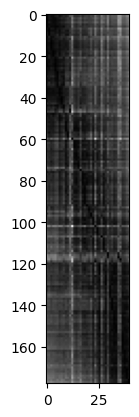

In [10]:
D = pairwise_squared_distance(X_scaled, L)
plt.imshow(D, cmap='gray')

In [11]:
sigma2, kernel_entropy, funcalls = maximize_kernel_entropy(D, n_bins=n_bins)
print(f"Optimal sigma2: {sigma2:.2f}, Kernel entropy: {kernel_entropy:.2f}, Function calls: {funcalls:d}")

Optimal sigma2: 12.80, Kernel entropy: 2.10, Function calls: 31


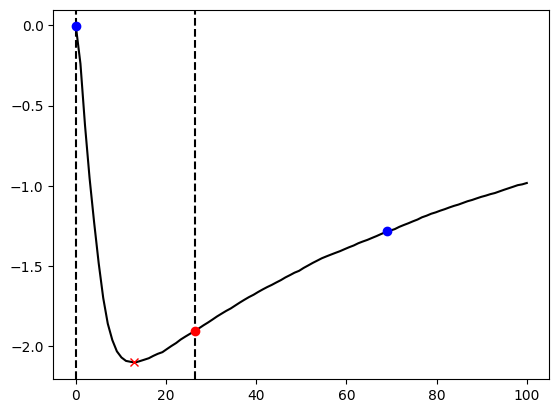

In [12]:
x = np.linspace(1e-10, 100, 100)
y = [negative_kernel_entropy(sigma2, D, n_bins=n_bins) for sigma2 in x]

xa_0 = 1e-10
xb_0 = np.mean(D)
fun = partial(negative_kernel_entropy, squared_distances=D, n_bins=n_bins)
xa, xb, xc, fa, fb, fc, _ = bracket(fun, xa_0, xb_0)

plt.plot(x, y, "-k")
plt.axvline(x=xa_0, color="k", linestyle="--")
plt.axvline(x=xb_0, color="k", linestyle="--")
plt.plot(xa, fa, "bo")
plt.plot(xb, fb, "ro")
plt.plot(xc, fc, "bo")
plt.plot(sigma2, -kernel_entropy, 'rx')

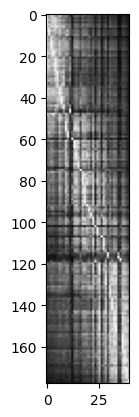

In [13]:
K = np.exp(-D / (2 * sigma2))
plt.imshow(K, cmap='gray')